# Description
In this notebook we will try to figure out the feasibility of the final step of the project.  To do this, we will (perhaps arbitrarily) choose a Lagrangian and write the Fokker-Planck equation associated to the Euler-Lagrange equations + noise.  Then we will code it using a Hermite basis.

##Our Lagrangian
Let let $Q = \mathbb{R}^2$.  For each $N \in \mathbb{N}$ we can consider the Lagrangian $L_N \in C^1(TQ)$ given by
$$L_N(q,v) = \frac{1}{2} \| v \|^2 - U_N(q)$$
where $q = (x,y)$ and $U_N(x,y) = \sum^{N,N}_{ k_x =0, k_y =0} \frac{1}{k_x k_y} H_{k_x}(x) H_{k_y}(y)$

##The Euler-Lagrange equations (+noise)
The stochastic Euler-Lagrange equation is
$$ dq = v dt \quad , \quad dv = - \nabla U_N(q)dt + \sigma^2 dW $$
This is just the standard Euler-Lagrange equation with a random force term given by white noise.
The term $\nabla U_N(q)$ can be written explicitly as
$$ \partial_x U_N(q) = \sum_{k_x,k_y} \frac{1}{k_x k_y} H'_{k_x} (x) H_{k_y} (y)$$


##The Fokker-Planck equation and the Shrodinger equation
The Fokker-Planck equation is
$$
    \partial_t \rho + \mathcal{L}_X[\rho] + \sigma^2 \Delta_{v} \rho = 0
$$
where $\Delta_v = -\partial_{v_x}^2 - \partial_{v_y}^2$ and $\mathcal{L}_X[\rho]$ is the Lie-derivative operator
$$
    \mathcal{L}_X[\rho] = v_x \partial_x \rho + v_y \partial_y \rho - \partial_x U_N \cdot \partial_{v_x} \rho - \partial_y U_N \cdot \partial_{v_y} \rho.
$$
The gradients of $U$ can be more explicitly written as
$$
    \partial_x U_n = \sum_{k_x=0,k_y=0}^{N,N} H_{k_x}'(x) H_{k_y}(y) = \sum_{k_x=1,k_y=0}^{N,N} 2k_x H_{k_x-1}(x) H_{k_y}(y) 
$$

Alternatively, if $\rho = |\psi|^2$ then
$$
    \partial_t \psi + \mathcal{L}_X[\psi] + \sigma i \nabla \psi = 0
$$
where $\mathcal{L}_{X}[\psi]$ is the Lie derivative for a half-density and $i\nabla$ is a Dirac operator.  However, this formulation provides little benefit in our scenario, since the vector-field is incompressible.

**TODO:  Is it $\sigma$ or $\sigma^2$?:**


##Hermite Spectral discretization
We use the Hermite functions
$$
    h_n(x) = c_n e^{-x^2 / 2 \sigma^2} H_n(x)
$$
where $c_n = \pi^{-1/4} (2^n n!)^{-1/2}$ and $H_n(x)$ is the $n$th (physicist's) Hermite polynomial generated via
$$
    H_{n+1}(x) = 2x H_{n}(x) - 2n H_{n-1}(x) 
$$
with $H_0(x)= 1$ and $H_1(x) = x$.


$$\psi_{0}(x)=\pi^{-1/4} e^{-x^2/2} $$

$$\psi_{1}(x)=\sqrt{2} \pi^{-1/4}x e^{-x^2 / 2}$$

###Recursion
The hermite functions are generated by the formula
$$
    h_n(x) = \sqrt{\frac{2}{n}} x h_{n-1}(x) - \sqrt{ \frac{n-1}{n} } h_{n-2}(x)
$$


### Important operators
The Hermite functions satisfy
$$
    \psi'_n(x) = \sqrt{ \frac{n}{2} } \psi_{n-1}(x) - \sqrt{ \frac{n+1}{2} } \psi_{n+1}(x)
$$
and
$$
    x \psi_n(x) = \sqrt{ \frac{n}{2} } \psi_{n-1}(x) + \sqrt{ \frac{n+1}{2} } \psi_{n+1}(x)
$$
which are sparse operations in this basis, so that polynomial vector fields with only a few terms are just compositions of sparse operators.

## Hermite approximation of a Gaussian
It would be nice to compute the integral
$$I =  \int \psi_n(x) e^{ - (x-x_0^2) / (2 \sigma^2) }dx = \int c_n e^{-x^2/2}e^{ - (x-x_0^2) / (2 \sigma^2) } H_n(x) $$

Gaussian quadrature says
$$\int f(x) \exp( - x^2 / 2) dx \approx \sum_{i=0}^{N} \omega_i f(x_i)$$
where $x_i$ are the roots of the $(N+1)$th Hermite polynomial

In [2]:
import numpy as np
from scipy import sparse

The formula is exact if the $f \in \mathbb{R}[2n]$ where $n$ is the number of nodes.

So for example, $\int \exp( -x^2) dx = \pi^{1/2}$

In [3]:
from numpy.polynomial import hermite
nodes,weights = hermite.hermgauss(100)
I = np.dot(weights, np.ones_like(nodes))
print I
print np.sqrt(np.pi)

1.77245385091
1.77245385091


To approximate a gaussian, just sample it at the nodes and use the above approximation with
$$
    f = c_n \exp( - x^2 / 2)

In [4]:
def hermite_function(x,max_degree=20):
    # computes h_n(x) for n = 0,...,max_degree
    out = np.zeros( (max_degree + 2 , x.size) )
    out[0,:] = np.pi**-0.25 * np.exp( - x**2 / 2.0)
    out[1,:] = np.sqrt(2)*x*out[0,:]
    for n in range(2,max_degree+1):
        out[n,:] = np.sqrt(2.0/n) * x * out[n-1,:] - np.sqrt( (n-1)/float(n)) * out[n-2,:]
    return out


def hermite_polynomial(x,deg):
    #computes the Hermite polynomials 0,...,deg at an array of points x.
    #returns a matrix of size (len(x),deg)
    H = np.zeros((deg+2, x.size) )
    H[0,:] = 1.0
    H[1,:] = 2*x
    for n in range(2,deg+2):
        H[n,:] = 2*x*H[n-1,:]-2*(n-1)*H[n-2,:]
    return H


In [5]:
mu = 0.2
sigma = 0.3
f = lambda x: np.exp( -(x-mu)**2 / (2.0*sigma**2) )
h_series = ( f(nodes)*hermite_function(nodes) ).dot(weights)

In [6]:
x = np.linspace(-2,2,1000)
deg = 10
y = hermite_function(x*np.sqrt(deg) , deg)
from scipy.misc import factorial
c = lambda n : np.pi**-0.25 *(factorial(n)*2**n)**(-0.5)
y2 = hermite_polynomial( x*np.sqrt(deg) , deg )*np.exp(-deg*x**2/2)

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

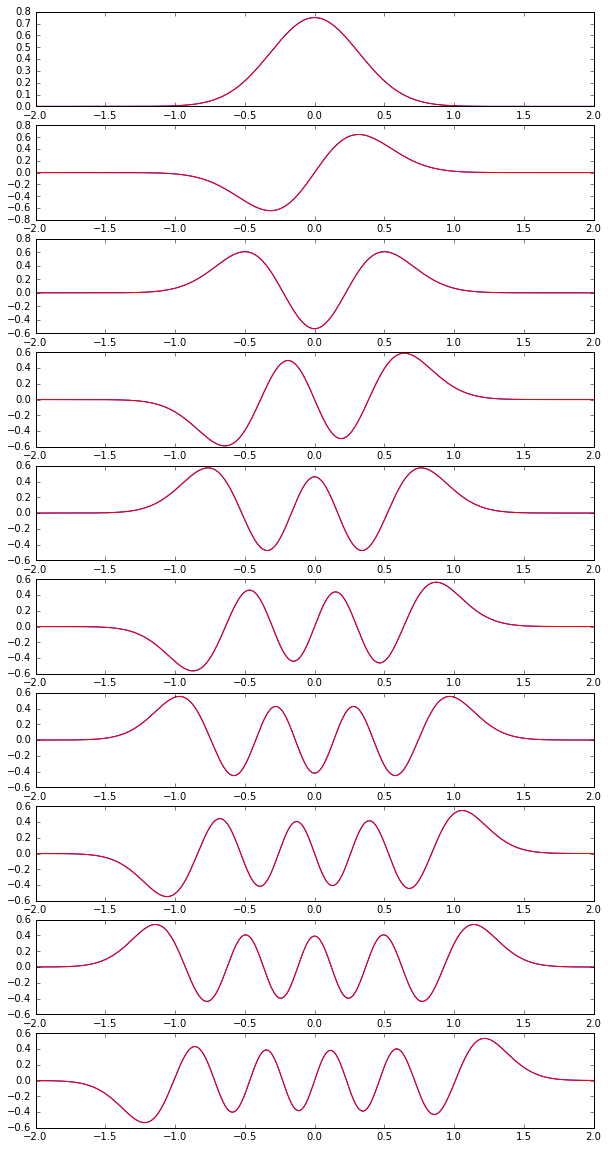

In [8]:
f,ax_arr = plt.subplots(deg,1, figsize = (10,20))
for n,ax in enumerate(ax_arr):
    ax.plot(x, y[n],'b-')
    ax.plot(x,c(n)*y2[n],'r-')

#Hermite function interpolation in one dimension
Now that we have the Hermite functions working, let's see if we can do one-dimensional interpolation.
Start by assuming $f(x) = \sum_n a_n h_n( \alpha x )$.
We desire to calculate the coefficients, $a_n$.
First note that if $\{ \gamma_0,\dots,\gamma_N\}$ are the Gaussian quadrature nodes,
then $\{ h_0,\dots, h_N\}$ satisfies the orthgonality condition
\begin{align}
    \sum_{i=0}^N h_m(\gamma_i) h_n(\gamma_i) C_i = \int h_m(x) h_n(x) dx = \delta_{mn} 
\end{align}
for some set of weights $C_i$, courtesy of Gaussian quadrature.
Thus $Q^T_{ni} = h_{n}(\gamma_i)/ \sqrt{C_i}$ is an orthogonal matrix.
This implies that the sum (obtained by transposition) satisfies an orthogonality relation
\begin{align}
    \sum_{n=0}^N h_n(\gamma_i) h_n(\gamma_j) = C_i \delta_{ij}
\end{align}
where $C_i = \sum_{n} (h_n(\gamma_i))^2$.

In other words, the matrix
$
    Q_{ni} = h_n(\gamma_i) / C_i^{1/2}
$
is an orthogonal matrix.
We can write $f(\gamma_i/\alpha) = \sum_n a_n h_n(\gamma_i) = \sum_n a_n Q_{ni} C_i^{1/2}$.
Rearranging we get $f(\gamma_i / \alpha) / C_i^{1/2} = a_n Q_{ni}$.
We can invert $Q$ by transposing it, to find $Q_{ni} f(\gamma_i  / \alpha ) / C_i^{1/2} = a_n$.
This yeilds
$$
    a_n = \sum_i h_n(\gamma_i) f(\gamma_i / \alpha) / C_i
$$
This is formula (2.11) of Tang 1993.

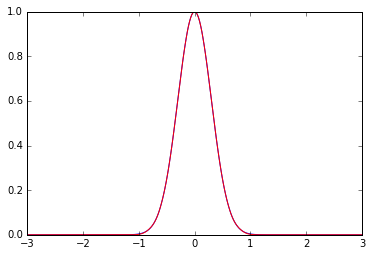

In [9]:
N=20
gamma,w = hermite.hermgauss(N)
H_at_nodes = hermite_polynomial( gamma , N )
sigma = 0.3
f = lambda x : np.exp( - x**2 / (2*sigma**2) )
alpha = np.sqrt(2*N)/1.0
h_at_nodes = hermite_function(gamma,N)
C = ( h_at_nodes**2 ).sum(axis=0)
a = h_at_nodes.dot( f(gamma/alpha) / C )

fine_grid = np.linspace(-3,3,300)
f_truncated = a.dot( hermite_function(fine_grid*alpha,N))

plt.plot( fine_grid , f(fine_grid) , 'b-')
plt.plot( fine_grid , f_truncated, 'r-')

## 2D interpolation and higher
We take tensor products of the concepts in the one-dimensional case in order to deal with the two-dimensional case.
So
\begin{align}
    f( x / \alpha , y/\alpha) = \sum_{n_1 , n_2} a_{n_1,n_2} h_{n_1}(x) h_{n_2}(y)
\end{align}
and the relevant orthgonality condition is
\begin{align}
    \sum_{n_1,n_2=0}^N h_{n_1}( \gamma_{i_1}) h_{n_2}( \gamma_{i_2}) h_{n_1}( \gamma_{j_1}) h_{n_2}( \gamma_{j_2}) 
    = C_{i_1} C_{i_2} \delta_{i_1 j_1} \delta_{i_2 j_2}
\end{align}
So that $Q_{ni} = ( h_{n_1}( \gamma_{i_1} )/C_{i_1}^{1/2} ) ( h_{n_2}( \gamma_{i_2}) / C_{i_2}^{1/2})$ is an orthogonal matrix.

Proceeding as before, if we evaluate $f$ on the nodes we find
\begin{align}
    f \left( \frac{ \gamma_{i_1} }{ \alpha} , \frac{ \gamma_{i_2} }{ \alpha } \right) &=
    \sum_{n_1 , n_2} a_{n_1,n_2} h_{n_1}( \gamma_{i_1} ) h_{n_2}( \gamma_{i_2} ) \\
    &= \sum_{n_1 , n_2} a_{n_1,n_2} Q_{ni} C_{i_1}^{1/2} C_{i_2}^{1/2}
\end{align}
By virtually, the same math as before we use the orthogonality of $Q$ to obtain
\begin{align}
    a_n = \sum_{i_1,i_2} h_{n_1}(\gamma_{i_1}) h_{n_2}(\gamma_{i_2})
    C^{-1}_{i_1} C^{-1}_{i_2}
    f \left( \frac{ \gamma_{i_1} }{ \alpha} , \frac{ \gamma_{i_2} }{ \alpha } \right).
\end{align}
From this excercise we can see that generally for $f$ a function in $\mathbb{R}^n$ that
\begin{align}
    f( \mathbf{x} / \alpha ) = \sum_{ \mathbf{n} } a_{\mathbf{n}} h_{\mathbf{n}}( \mathbf{x}  )
\end{align}
then
\begin{align*}
    a_{\mathbf{n}} = \sum_{\mathbf{i}} h_{\mathbf{n}}( \gamma_{\mathbf{i}}) C^{-1}_{\mathbf{i}} f( \gamma_{\mathbf{i}} / \alpha )
\end{align*}
where bold math fonts correspond to natural generalization to multi-indices.  In particular
\begin{align*}
    \gamma_{\mathbf{i}} &= ( \gamma_0, \dots, \gamma_N) \\
    h_{\mathbf{n}}( \mathbf{x}) &= \prod_{k=0}^N h_{n_k}( x_k) \\
    C_{\mathbf{i}} &= \prod_{k=0}^N C_{i_k}
\end{align*}


In [22]:
sigma = 0.5
f = lambda x,y : np.exp( -(x**2+y**2)/(2*sigma**2))
x_gamma,y_gamma = np.meshgrid( gamma , gamma )
a = np.einsum('mi,nj,i,j,ij->mn',h_at_nodes,h_at_nodes,C**-1,C**-1,f( x_gamma/alpha,y_gamma/alpha ))

fine = np.linspace(-2,2,50)
x_grid,y_grid = np.meshgrid( fine, fine)
h_fine = hermite_function( fine*alpha )
f_truncated = np.einsum('mn,mi,nj->ij',a,h_fine,h_fine)

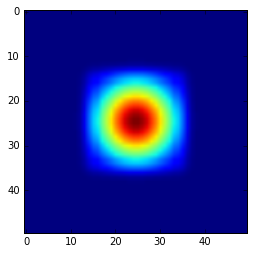

In [23]:
plt.imshow( f_truncated )

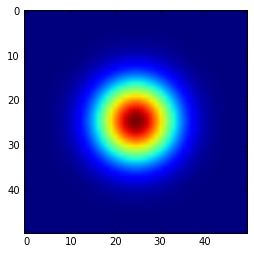

In [24]:
plt.imshow( f(x_grid,y_grid))